Persian extractive question answering system (PQUAD dataset) by fine-tuning bert based models (without using automodles for question answering)

فراخوانی کتابخانه‌ها و درخواست مجوز برای دسترسی به درایو

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install datasets
!pip install transformers
from tqdm import tqdm
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.0 MB/s eta 0:00:00


فراخوانی دیتاست، توکنایزرهای مدل‌های از پیش آموزش دیده‌ی ذکر شده در سوال و خود مدل‌های ذکر شده در سوال

In [2]:
raw_datasets = load_dataset("Gholamreza/pquad")
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')
bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/63994 [00:00<?, ? examples/s]

/root/.cache/huggingface/datasets/downloads/e49d5f650d69a5999fe6ceb4438a023cccdcf3e6519abc4dabce736f91595591


Generating validation split:   0%|          | 0/7976 [00:00<?, ? examples/s]

/root/.cache/huggingface/datasets/downloads/ea42ddfa9db6f39bc3249a878c853a6f6b466f6217a360bbb8afbac9410d84cc


Generating test split:   0%|          | 0/8002 [00:00<?, ? examples/s]

/root/.cache/huggingface/datasets/downloads/d6ba3b80ff2a6d0333454fac286694b5e777518ea141e0dcd7c0558b71624882
Dataset pquad downloaded and prepared to /root/.cache/huggingface/datasets/Gholamreza___pquad/pquad/1.0.0/ce0e1bf6a7a67398a195ccb3a16263336e977abad6e67800390346e8d9530ab0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of the model checkpoint at HooshvareLab/bert-fa-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<div dir='rtl'>
  شَمای کلی مدل ParsBert:
</div>

In [3]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(100000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

<div dir='rtl'>
در دیتاست سوال شروع و پایان جواب به وسیله‌ی اندیس کاراکتر مشخص شده است. با توجه به منابع و زمان محدودی که در اختیار داریم، برای آموزش مدل بهتر است از اندیس توکن شروع جواب و انتهای جواب به جای اندیس کاراکتر استفاده کنیم. برای این منظور تابع get_tokens_span تعریف شد.
<br>
 همچنین در همین بخش کلاس دیتاست و دیتالودر تعریف شدند. کلاس دیتاست برای تبدیل اندیس کاراکترها به اندیس توکن‌ها از تابع ذکر شده استفاده میکند. همچنین طول تمام جملات با استفاده از padding برابر 200 در نظر گرفته شد هر چند بهتر بود به جای آنکه تمام جملات دیتاست را برابر 200 در نظر بگیریم، آنها را برابر طول بلندترین جمله‌ای که در batch مشترک با آنها قرار دارد در نظر بگیریم. منظور از طول جمله، تعداد توکن‌های توالی متشکل از جمله‌ی سوال و متن (دو ستون question و context) و همچنین توکن‌های کنترلی (مثل [CLS] و [SEP]) برای هر سطر است.
 در صورتی که سوال فاقد پاسخ باشد، توکن شروع و پایان پاسخ برابر توکن اول ([CLS]) در نظر گرفته می‌شود.
</div>

In [4]:
def get_tokens_span_2(larger_sequence_tokenized, smaller_sequence_tokenized):
  start_index = None
  end_index = None
  for i in range(len(larger_sequence_tokenized["input_ids"]) - len(smaller_sequence_tokenized['input_ids']) + 1):
      if larger_sequence_tokenized["input_ids"][i:i+len(smaller_sequence_tokenized['input_ids'])] == smaller_sequence_tokenized['input_ids']:
          start_index = i
          end_index = i + len(smaller_sequence_tokenized['input_ids']) - 1 #19 + 3 = 22 but we want 19, 20, 21 and this is equal to [19:22]. any way, we return first and last index. 19 and 21
          break
  return start_index, end_index

class PquadDataset(Dataset):
    def __init__(self, tokenizer, raw_datasets, max_len):
      self.tokenizer = tokenizer
      self.max_len = max_len
      self.raw_ds = raw_datasets

    def __len__(self):
        return len(self.raw_ds)

    def __getitem__(self, index):
      #tokenized_inputs = self.tokenizer.encode_plus(self.raw_ds[index]['question'], self.raw_ds[index]['context'], max_length=self.max_len, truncation=True, padding='max_length')
      tokenized_inputs = self.tokenizer.encode_plus(self.raw_ds[index]['question'], self.raw_ds[index]['context'], max_length=self.max_len, truncation="only_second", padding='max_length')
      input_ids = tokenized_inputs['input_ids']
      token_type_ids = tokenized_inputs['token_type_ids']
      attention_mask = tokenized_inputs['attention_mask']
      if len(self.raw_ds[index]['answers']['text']) > 0:
        answer_start, answer_end = get_tokens_span_2(tokenized_inputs, self.tokenizer(self.raw_ds[index]['answers']['text'][0] ,add_special_tokens=False))
      else:
        answer_start, answer_end = None, None
      #if answer_end < max_len ## we will not implent this due shortage of time (at least meanwhile)

      #data_loader can't get None as input
      if answer_start is None or answer_end is None:
        answer_start, answer_end = 0, 0
      return {
          'input_ids': torch.tensor(input_ids),
          'token_type_ids': torch.tensor(token_type_ids),
          'attention_mask': torch.tensor(attention_mask),
          'answer_start': answer_start,
          'answer_end': answer_end,
      }

#train_ds = PquadDataset(tokenizer, raw_datasets['train'], 400) #ّtrain dataset bert base model
train_ds = PquadDataset(tokenizer, raw_datasets['train'], 200) #ّtrain dataset bert base model
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=2, pin_memory=True) #train dataloader for bert base model

<div dir='rtl'>
دیتاست فوق برای دسته‌ی train تعریف شد. با توجه به تفاوت جزئی در دسته‌های test و validation (وجود سطرهایی در دیتاست این دو دسته که بیش از یک پاسخ دارند ) کلاس دیتاست متفاوتی برای این دو دسته تعریف میکنیم. می‌توانستیم کلاس فوق را برای این مورد شخصی سازی کنیم ولی با توجه به نزدیک بودن ددلاین کلاس متفاوتی تعریف شد تا نیاز به ویرایش سایر بخش‌های کد نباشد.
</div>

In [5]:
class PquadTestDataset(Dataset):
    def __init__(self, tokenizer, raw_datasets, max_len):
      self.tokenizer = tokenizer
      self.max_len = max_len
      self.raw_ds = raw_datasets

    def __len__(self):
        return len(self.raw_ds)

    def __getitem__(self, index):
      #tokenized_inputs = self.tokenizer.encode_plus(self.raw_ds[index]['question'], self.raw_ds[index]['context'], max_length=self.max_len, truncation=True, padding='max_length')
      tokenized_inputs = self.tokenizer.encode_plus(self.raw_ds[index]['question'], self.raw_ds[index]['context'], max_length=self.max_len, truncation="only_second", padding='max_length')
      input_ids = tokenized_inputs['input_ids']
      token_type_ids = tokenized_inputs['token_type_ids']
      attention_mask = tokenized_inputs['attention_mask']
      ans_num = len(self.raw_ds[index]['answers']['text'])
      #print(self.raw_ds[index]['answers']['text'])
      #print("SDSFSD", ans_num)
      if ans_num == 1:
        #print('=1')
        answer_start, answer_end = get_tokens_span_2(tokenized_inputs, self.tokenizer(self.raw_ds[index]['answers']['text'][0] ,add_special_tokens=False))
      elif len(self.raw_ds[index]['answers']['text']) > 1:
        #print('<1')
        answer_start = []
        answer_end = []
        for i in range(ans_num):
          s, e  = get_tokens_span_2(tokenized_inputs, self.tokenizer(self.raw_ds[index]['answers']['text'][i] ,add_special_tokens=False))
          if s is None:
            s = 0
          if e is None:
            e = 0
          answer_start.append(s)
          answer_end.append(e)
        #answer_start = torch.tensor(answer_start)
        #answer_end = torch.tensor(answer_end)
      else:
        #print('=0')
        answer_start, answer_end = 0, 0
      #if answer_end < max_len ## we will not implent this due shortage of time (at least meanwhile)

      #data_loader can't get None as input
      if answer_start is None or answer_end is None:
        answer_start, answer_end = 0, 0

      return {
          'input_ids': torch.tensor(input_ids),
          'token_type_ids': torch.tensor(token_type_ids),
          'attention_mask': torch.tensor(attention_mask),
          'answer_start': answer_start,
          'answer_end': answer_end,
      }


def custom_collator(data):
  return data

#test_ds = PquadTestDataset(tokenizer, raw_datasets['test'], 400) #test dataset bert base model
test_ds = PquadTestDataset(tokenizer, raw_datasets['test'], 500) #test dataset bert base model
test_loader = DataLoader(test_ds, batch_size=4, collate_fn= custom_collator, shuffle=True, num_workers=2, pin_memory=True) #test dataloader for bert base model

مدل طراحی شده برای سوال. شامل دو لایه: لایه اول، در حقیقت مدل برت محور است که خروجی توکنایز شده را دریافت میکند و لایه‌ی دوم خروجی لایه اول را دریافت کرده و شانس هر توکن برای آنکه توکن شروع جواب و توکن انتهای جواب باشد را برمیگرداند.

In [6]:
class PquadModel(torch.nn.Module):
  def __init__(self, base_model):
      super().__init__()
      self.base_model = base_model
      self.qa_outputs = torch.nn.Linear(base_model.config.hidden_size, 2)

  def forward(self, input_ids, token_type_ids, attention_mask):
      outputs = self.base_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
      sequence_output = outputs.last_hidden_state
      logits = self.qa_outputs(sequence_output)
      #return logits.T[0], logits.T[1] #######
      start_logits, end_logits = logits.split(1, dim=-1)
      start_logits = start_logits.squeeze(-1)
      end_logits = end_logits.squeeze(-1)
      return start_logits, end_logits


<div dir='rtl'>
شَمای مدل کلاس فوق در صورت استفاده از parsBert به عنوان لایه‌ی اول:
</div>

In [7]:
model = PquadModel(bert)
for _, param in model.base_model.named_parameters():
  param.requires_grad = True
model.eval

<bound method Module.eval of PquadModel(
  (base_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

<div dir='rtl'>
آموزش مدل به اندازه‌ی یک ایپاک (با توجه به محدودیت زمانی و سخت افزاری).
</br>
همچنین پارامترهای آموزش در 4 خط اول بلوک مشخص شده اند.
</div>

In [8]:
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
loss_fn = torch.nn.CrossEntropyLoss()
#epochs = 0.5
#max_batch_iteration = len(train_loader)/2 #== 2000 iteration
max_batch_iteration = np.inf
current_batch_iteration = 0

loss_history_per_batch = []#per batch
for epoch in range(1):
    model.train()
    epoch_loss = 0
    for idx, batch in tqdm(enumerate(train_loader)):
      #print((input_ids))
      input_ids = batch['input_ids'].to(device)
      token_type_ids = batch['token_type_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      answer_start = batch['answer_start'].to(device)
      answer_end = batch['answer_end'].to(device)

      output = model(input_ids, token_type_ids, attention_mask)

      start_loss = loss_fn(output[0], answer_start) #output[0] = start
      end_loss = loss_fn(output[1], answer_end)
      loss = (start_loss + end_loss) / 2
      loss_history_per_batch.append(loss)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step

      if max_batch_iteration <= idx:
        break



    #print(loss_history[-1])


torch.save(model.state_dict(), '/content/drive/MyDrive/nn5_2.pth')

tmp = []
[tmp.append(i.cpu().tolist()) for i in loss_history_per_batch]
loss_history_per_batch = tmp
del tmp
loss_history_per_batch
#with open('/content/drive/MyDrive/nn5_loss_hist.pickle', 'wb') as handle:
#    pickle.dump(loss_history_per_batch, handle, protocol=pickle.HIGHEST_PROTOCOL)

4000it [40:51,  1.63it/s]


[5.565794944763184,
 5.185654640197754,
 5.08564567565918,
 4.705660820007324,
 4.459588527679443,
 4.108157157897949,
 4.219536781311035,
 3.696570873260498,
 4.086935997009277,
 3.2684974670410156,
 3.448619842529297,
 3.896739959716797,
 3.631471633911133,
 3.9878764152526855,
 3.641780376434326,
 3.307488441467285,
 3.5742807388305664,
 3.6515064239501953,
 2.458747386932373,
 3.3010401725769043,
 3.6225898265838623,
 2.8639540672302246,
 3.5361075401306152,
 2.6074936389923096,
 2.453752040863037,
 2.4910922050476074,
 2.440247058868408,
 2.3030452728271484,
 2.877718925476074,
 2.9803483486175537,
 2.6956052780151367,
 2.4863228797912598,
 2.1479239463806152,
 2.5535826683044434,
 2.869302272796631,
 1.5336395502090454,
 1.764190673828125,
 2.1350128650665283,
 2.441897392272949,
 1.4765137434005737,
 1.8555397987365723,
 2.347407341003418,
 2.362407684326172,
 1.753176212310791,
 2.4137587547302246,
 1.8603744506835938,
 2.0458474159240723,
 1.7977499961853027,
 1.97108650207519

<div dir='rtl'>
مقدار loss به ازای هر بچ در نمودار اول و به ازای هر 100 بچ در نمودار دوم.
</div>

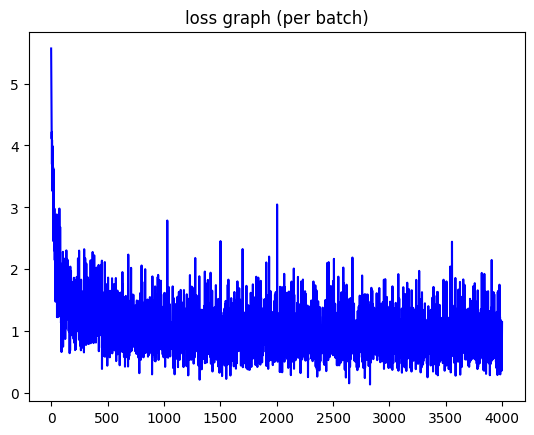

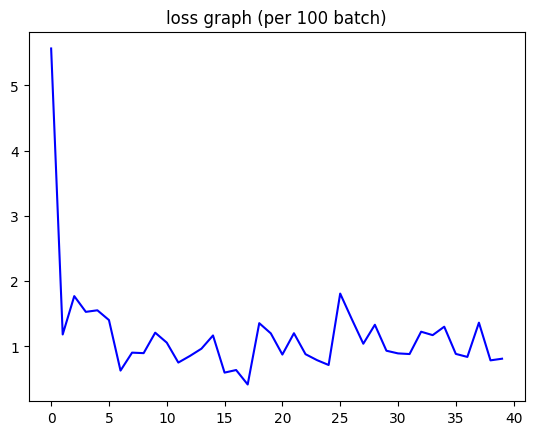

In [9]:
x = [i for i in range(len(loss_history_per_batch))]
y = loss_history_per_batch
plt.title("loss graph (per batch)")
plt.plot(x, y, color ="blue")
plt.show()

x = [i for i in range(len(loss_history_per_batch[::100]))]
y = loss_history_per_batch[::100]
plt.title("loss graph (per 100 batch)")
plt.plot(x, y, color ="blue")
plt.show()

آزمایش چند سطر از دیتاست تست و مقایسه خروجی واقعی و خروجی مدل

In [10]:
start_preds = []
start_true = []
end_preds = []
end_true = []
examples_index = torch.randint(8002, (1,4))[0] #8002 test set len
model.eval()
with torch.no_grad():
  for i in (examples_index):
      batch = test_ds[i.tolist()]
      input_ids = torch.unsqueeze((batch['input_ids'].to(device)), 0)
      token_type_ids = torch.unsqueeze((batch['token_type_ids'].to(device)), 0)
      attention_mask = torch.unsqueeze((batch['attention_mask'].to(device)), 0)
      answer_start = batch['answer_start']
      answer_end = batch['answer_end']
      output = model(input_ids, token_type_ids, attention_mask)
      pred_ans_start = torch.argmax(output[0], 1).cpu()
      pred_ans_end = torch.argmax(output[1], 1).cpu()
      #print('     true ans_start labels: ', answer_start)
      #print('predicted ans_start labels: ', pred_ans_start)
      #print('\n     true ans_end labels: ', answer_end)
      #print('predicted ans_end labels: ',pred_ans_end )
      #print('\n___________________________________________________\n')

      if type(answer_start) is list:
        ans_s = answer_start[0]
        ans_e = answer_end[0]
      else:
        ans_s = answer_start
        ans_e = answer_end
      print('example: ')
      original_text = tokenizer.decode(input_ids[0])
      #original_text = " ".join(original_text).replace("##", " ")
      true_ans_text = tokenizer.decode(input_ids[0][ans_s:ans_e+1])
      #true_ans_text = " ".join(true_ans_text).replace("##", " ")
      if ans_s == 0:
        true_ans_text = 'NO ANSWER PROVIDED'
      pred_ans_text = tokenizer.decode(input_ids[0][pred_ans_start:pred_ans_end+1])
      #pred_ans_text = " ".join(pred_ans_text).replace("##", " ")
      if pred_ans_start == 0 or (pred_ans_end < pred_ans_start):
        pred_ans_text = 'NO ANSWER PROVIDED'
      print("QUESTION: ", original_text.split('[SEP]')[0])
      print("TRUE ANSWER: ", true_ans_text)
      print("PREDICTED ANSWER: ", pred_ans_text)
      print('\n')



example: 
QUESTION:  [CLS] کدام بخش بهرام یشت از زمره بخشهایی است که حاصل تلفیق اعتقادات پیش از زرتشت و عقاید زرتشتی است ؟ 
TRUE ANSWER:  بند ۲۸ تا ۳۳
PREDICTED ANSWER:  بند ۲۸ تا ۳۳


example: 
QUESTION:  [CLS] چه عوامل نابسامان داخلی در جنگ جهانی اول در شکست روسیه بسیار موثر بود ؟ 
TRUE ANSWER:  اجتماعی کشاورزی و فرماندهی نظامی
PREDICTED ANSWER:  اجتماعی کشاورزی و فرماندهی نظامی


example: 
QUESTION:  [CLS] چند درصد از مساحت ژاپن بیابانی است ؟ 
TRUE ANSWER:  NO ANSWER PROVIDED
PREDICTED ANSWER:  NO ANSWER PROVIDED


example: 
QUESTION:  [CLS] سلطان قلیچ اول پس از جنگهای صلیبی با کدام امپراتوری پیمان بست ؟ 
TRUE ANSWER:  بیزانس ، الکسیوس
PREDICTED ANSWER:  امپراتور بیزانس ، الکسیوس




در این بلوک متریکهای خواسته شده حساب و نمایش داده میشوند.

In [12]:
import numpy as np

def calculate_f1score(references, predict):
  max_f1score = -1
  precision = -1
  recall = -1
  em = 0
  for ref in references:
    correct_words = len(set(ref) & set(predict))
    prec = correct_words/len(predict)
    rec = correct_words/len(ref)
    if prec + rec == 0:
      f1score = 0
      precision = prec
      recall = rec
    else:
      f1score = 2 * (prec * rec) / (prec + rec)
      precision = prec
      recall = rec
    if f1score > max_f1score:
      max_f1score = f1score
    if predict == ref:
      em = 1
  return max_f1score, precision, recall, em

f1scores = []
precisions = []
recalls = []
em = 0
model.eval()
with torch.no_grad():
  for batch in tqdm(test_ds):
      input_ids = torch.unsqueeze((batch['input_ids'].to(device)), 0)
      token_type_ids = torch.unsqueeze((batch['token_type_ids'].to(device)), 0)
      attention_mask = torch.unsqueeze((batch['attention_mask'].to(device)), 0)
      answer_start = batch['answer_start']
      answer_end = batch['answer_end']
      output = model(input_ids, token_type_ids, attention_mask)
      pred_ans_start = torch.argmax(output[0], 1)[0].cpu().tolist()
      pred_ans_end = torch.argmax(output[1], 1)[0].cpu().tolist()
      if pred_ans_start > pred_ans_end:
        pred_ans_start = 0
        pred_ans_end = 0
      all_answers = []
      pred_answer = None
      if not (type(answer_start) is list):
        answer_start = [answer_start]
        answer_end = [answer_end]
      for i in range(len(answer_start)):
        ans = tokenizer.decode(input_ids[0][answer_start[i]:answer_end[i]+1]).split()
        all_answers.append(ans)
        pred_answer = (tokenizer.decode(input_ids[0][pred_ans_start:pred_ans_end+1])).split()
      f1s, prec, rec, e = calculate_f1score(all_answers, pred_answer)
      f1scores.append(f1s)
      precisions.append(prec)
      recalls.append(rec)
      em += e

100%|██████████| 8002/8002 [05:20<00:00, 24.98it/s]


In [14]:
print("\nPrecision: ", np.mean(precisions))
print('Recall: ', np.mean(recalls))
print('f1score: ', np.mean(f1scores))
print('EM: ', em/len(test_ds))


Precision:  0.8120734550625853
Recall:  0.812581819902758
f1score:  0.818848965170571
EM:  0.6922019495126218


با استفاده از مدل البرت فارسی به جای پارسبرت، نتایج بهتری نیز حاصل گردید. البته نتایج فوق مشابه نتایج ذکر شده در مقاله دیتاست هستند.